In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pickle
from tqdm import tqdm
import importlib

from celara import KeplerLCPreprocessor, KeplerFeatureExtractor
from celara_utils import *
from celara_model import *

/home/kareem/Nasa_25-26/nasa_25-26/venv/lib/python3.10/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(
2025-10-05 21:28:42.403399: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-05 21:28:42.486041: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-05 21:28:44.297475: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/kareem/Nasa_25-26/nasa_25-26/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found

In [2]:
DATA_PATH = "data"
os.makedirs(DATA_PATH, exist_ok=True)

KOI_DOWNLOADED_ALREADY = os.path.exists(f"{DATA_PATH}/kepler_koi_dr25.csv") 
LIGHT_CURVES_TO_DOWNLOAD = 10
BALANCED_SUBSET_DOWNLOADED = os.path.exists(f"{DATA_PATH}/koi_balanced_subset.csv")

# 1.Load Data (KOI, Lightcurves)

In [3]:
url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+q1_q17_dr25_koi&format=csv"

if not KOI_DOWNLOADED_ALREADY and not BALANCED_SUBSET_DOWNLOADED:
    koi_df = pd.read_csv(url)
    koi_df.to_csv(f"{DATA_PATH}/kepler_koi_dr25.csv", index=False)
else:
    koi_df = pd.read_csv(f"{DATA_PATH}/kepler_koi_dr25.csv")

In [4]:
removed_candidates = koi_df[~koi_df["koi_disposition"].isin(["CONFIRMED", "FALSE POSITIVE"])]
koi_df = koi_df[koi_df["koi_disposition"].isin(["CONFIRMED", "FALSE POSITIVE"])].copy()

label_map = {"CONFIRMED": 1, "FALSE POSITIVE": 0}
koi_df["label"] = koi_df["koi_disposition"].map(label_map)

print("Removed candidates (not confirmed or false positive):", removed_candidates.shape[0])
print(koi_df["koi_disposition"].value_counts())
print("Labeled dataset ready, shape:", koi_df.shape)
koi_df.to_csv(f"{DATA_PATH}/kepler_koi_dr25_cleaned.csv", index=False)

Removed candidates (not confirmed or false positive): 1360
koi_disposition
FALSE POSITIVE    3965
CONFIRMED         2729
Name: count, dtype: int64
Labeled dataset ready, shape: (6694, 154)


In [5]:
if LIGHT_CURVES_TO_DOWNLOAD == 0:
    if os.path.exists(f"{DATA_PATH}/lightcurves"):
        print(f"Lightcurves already downloaded at '{DATA_PATH}/lightcurves', skipping download step.")
    else:
        print(f"Lightcurves download flag is set, but {DATA_PATH}/lightcurves does not exist. Please check.")
else:
    confirmed = koi_df[koi_df["koi_disposition"] == "CONFIRMED"]
    false_positive = koi_df[koi_df["koi_disposition"] == "FALSE POSITIVE"]

    samples_per_class = LIGHT_CURVES_TO_DOWNLOAD // 2

    print(f"Available data:")
    print(f"  Confirmed planets: {len(confirmed)}")
    print(f"  False positives: {len(false_positive)}")
    print(f"Balanced sampling:")
    print(f"  Taking {samples_per_class} from each class = {samples_per_class * 2} total")

    confirmed_sample = confirmed.sample(samples_per_class, random_state=42)
    fp_sample = false_positive.sample(samples_per_class, random_state=42)

    balanced_subset = pd.concat([confirmed_sample, fp_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Balanced subset verification:")
    print(balanced_subset["koi_disposition"].value_counts())
    print(f"Total samples: {len(balanced_subset)}")

    balanced_subset.to_csv("data/koi_balanced_subset.csv", index=False)
    print(f"Saved balanced dataset: data/koi_balanced_subset.csv")

    subset_results = fetch_lightcurves(balanced_subset["kepid"].tolist(), sleep=0.5, overwrite=False)
    print(f"Download results:")
    print(subset_results["success"].value_counts())
    if "error" in subset_results.columns:
        print("Error breakdown:")
        print(subset_results['error'].value_counts())

Available data:
  Confirmed planets: 2729
  False positives: 3965
Balanced sampling:
  Taking 5 from each class = 10 total
Balanced subset verification:
koi_disposition
FALSE POSITIVE    5
CONFIRMED         5
Name: count, dtype: int64
Total samples: 10
Saved balanced dataset: data/koi_balanced_subset.csv


Fetching Kepler light curves:   0%|          | 0/10 [00:00<?, ?it/s]

Fetching Kepler light curves:  10%|█         | 1/10 [04:02<36:21, 242.42s/it]



KeyboardInterrupt: 

# 2. Processing (Masking, normalisation, detrending, feature extraction)

In [ ]:
lightcurve_dir = f"{DATA_PATH}/lightcurves"

if 'balanced_subset' in locals():
    dataset_to_process = balanced_subset
    print(f"Using balanced_subset: {dataset_to_process.shape}")
    print(f"Class balance: {dataset_to_process['koi_disposition'].value_counts().to_dict()}")
else:
    print("No balanced_subset found. Run cell 6 first to create balanced dataset.")
    dataset_to_process = None

if dataset_to_process is not None:
    print(f"Processing {len(dataset_to_process)} samples from balanced dataset...")
    X, y = process_kepler_dataset(dataset_to_process, lightcurve_dir, path=DATA_PATH, save_name="features_balanced")

    if X is not None:
        print(f"Processing Results:")
        print(f"   Features shape: {X.shape}")
        print(f"   Labels: {np.bincount(y)} (0=FP, 1=Confirmed)")
        print(f"   Ready for neural network training!")
else:
    print("Cannot process - no dataset available")

Using balanced_subset: (10, 154)
Class balance: {'FALSE POSITIVE': 5, 'CONFIRMED': 5}
Processing 10 samples from balanced dataset...
Processing 10 samples from dataset...


Building file index: 100%|██████████| 827/827 [00:00<00:00, 779831.25it/s]

File index: 827 files
Available lightcurves: 10/10


Processing lightcurves: 100%|██████████| 10/10 [00:01<00:00,  5.11it/s]

✅ Successfully processed 10 samples
   Shape: (10, 2206)
   Labels: [5 5] (0=FP, 1=Confirmed)
   Saved: data/features_balanced.npz
Processing Results:
   Features shape: (10, 2206)
   Labels: [5 5] (0=FP, 1=Confirmed)
   Ready for neural network training!


# 3. Multi-Modal ResNet Model

In [ ]:
print("Creating simple ResNet CNN model...")

# Import the function from celara_model if not already imported
from celara_model import create_simple_resnet_trimodal

model = create_simple_resnet_trimodal()

model.summary()

param_count = model.count_params()

try:
    os.makedirs('models/architectures', exist_ok=True)
    tf.keras.utils.plot_model(
        model, 
        show_shapes=True, 
        show_layer_names=True, 
        to_file='models/architectures/simple_resnet_architecture.png', 
        dpi=150,
        rankdir='TB'
    )
    print("Simple ResNet architecture saved to 'models/architectures/simple_resnet_architecture.png'")
except Exception as e:
    print(f"Plot failed: {e}")

Creating simple ResNet CNN model...


2025-10-05 21:28:05.502111: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-05 21:28:05.766456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-05 21:28:08.103431: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-05 21:28:08.103431: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-05 21:28:09.824710: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-10-05 21:28:09.824710: E external/local_xla/xla/stream_e

Model: "ResNet_Exoplanet_2M"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ local_view          │ (None, 201)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_view         │ (None, 2001)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 201, 1)    │          0 │ local_view[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 2001, 1)   │          0 │ global_view[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 201, 64)   │        384 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 2001, 64)  │        512 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 201, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2001, 64)  │        256 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 100, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 64)   │     20,544 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 400, 64)   │     20,544 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 100, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 400, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 100, 64)   │          0 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 400, 64)   │          0 │ re_lu_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 100, 64)   │     20,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 400, 64)   │     20,544 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_2[0][0]  

 Total params: 2,592,833 (9.89 MB)

 Trainable params: 2,581,953 (9.85 MB)

 Non-trainable params: 10,880 (42.50 KB)

Plot failed: name 'os' is not defined


In [ ]:
print("Loading processed features...")

data = np.load(f'{DATA_PATH}/features_balanced.npz')
X_full, y_full = data['X'], data['y']

print(f"Loaded data shape: {X_full.shape}, Labels: {y_full.shape}")
print(f"Class distribution: {np.bincount(y_full)} (0=False Positive, 1=Confirmed)")

print("Splitting features into modalities...")
local_features = X_full[:, :201]
global_features = X_full[:, 201:2202]
aux_features = X_full[:, 2202:]

print("Creating train/validation/test splits...")
X_local_temp, X_local_test, X_global_temp, X_global_test, X_aux_temp, X_aux_test, y_temp, y_test = train_test_split(
    local_features, global_features, aux_features, y_full, 
    test_size=0.2, stratify=y_full, random_state=42
)

X_local_train, X_local_val, X_global_train, X_global_val, X_aux_train, X_aux_val, y_train, y_val = train_test_split(
    X_local_temp, X_global_temp, X_aux_temp, y_temp, 
    test_size=0.4, stratify=y_temp, random_state=42
)

print(f"Training set: {X_local_train.shape[0]} samples")
print(f"Validation set: {X_local_val.shape[0]} samples") 
print(f"Test set: {X_local_test.shape[0]} samples")

print("Data prepared for training!")

Loading processed features...


NameError: name 'np' is not defined

In [ ]:
print("Setting up simple training strategy for ResNet CNN...")

from sklearn.utils.class_weight import compute_class_weight

epochs = 50
batch_size = 32
learning_rate = 1e-3

print(f"Training Configuration:")
print(f"   Epochs: {epochs}")
print(f"   Batch size: {batch_size}")
print(f"   Learning rate: {learning_rate} (fixed)")

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

print("Compiling simple ResNet model...")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

print("Setting up simple training callbacks...")
callbacks_list = get_simple_callbacks(
    model_path='models/keras/simple_resnet_model.keras',
    patience=15,
    factor=0.5,
    min_lr=1e-6
)

print(f"Starting simple ResNet training:")
print(f"   Binary crossentropy loss")
print(f"   Class weights: {class_weight_dict}")
print(f"   Fixed learning rate: {learning_rate}")
print(f"   {epochs} epochs with early stopping (patience=15)")
print(f"   Monitoring accuracy for best model selection")
print(f"   Batch size: {batch_size}")

print(f"Training simple ResNet model...")
history = model.fit(
    [X_local_train, X_global_train, X_aux_train],
    y_train,
    validation_data=([X_local_val, X_global_val, X_aux_val], y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    class_weight=class_weight_dict,
    verbose=1
)

Setting up simple training strategy for ResNet CNN...
Training Configuration:
   Epochs: 50
   Batch size: 32
   Learning rate: 0.001 (fixed)
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}
Compiling simple ResNet model...
Setting up simple training callbacks...
Starting simple ResNet training:
   Binary crossentropy loss
   Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}
   Fixed learning rate: 0.001
   50 epochs with early stopping (patience=15)
   Monitoring accuracy for best model selection
   Batch size: 32
Training simple ResNet model...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5000 - auc: 0.5000 - loss: 0.8654 - precision: 0.5000 - recall: 0.5000
Epoch 1: val_accuracy improved from None to 0.50000, saving model to models/keras/simple_resnet_model.keras

Epoch 1: val_accuracy improved from None to 0.50000, saving model to models/keras/simple_resnet_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.5000 - auc: 0.5000 - loss: 0.865

Simple ResNet Training History:


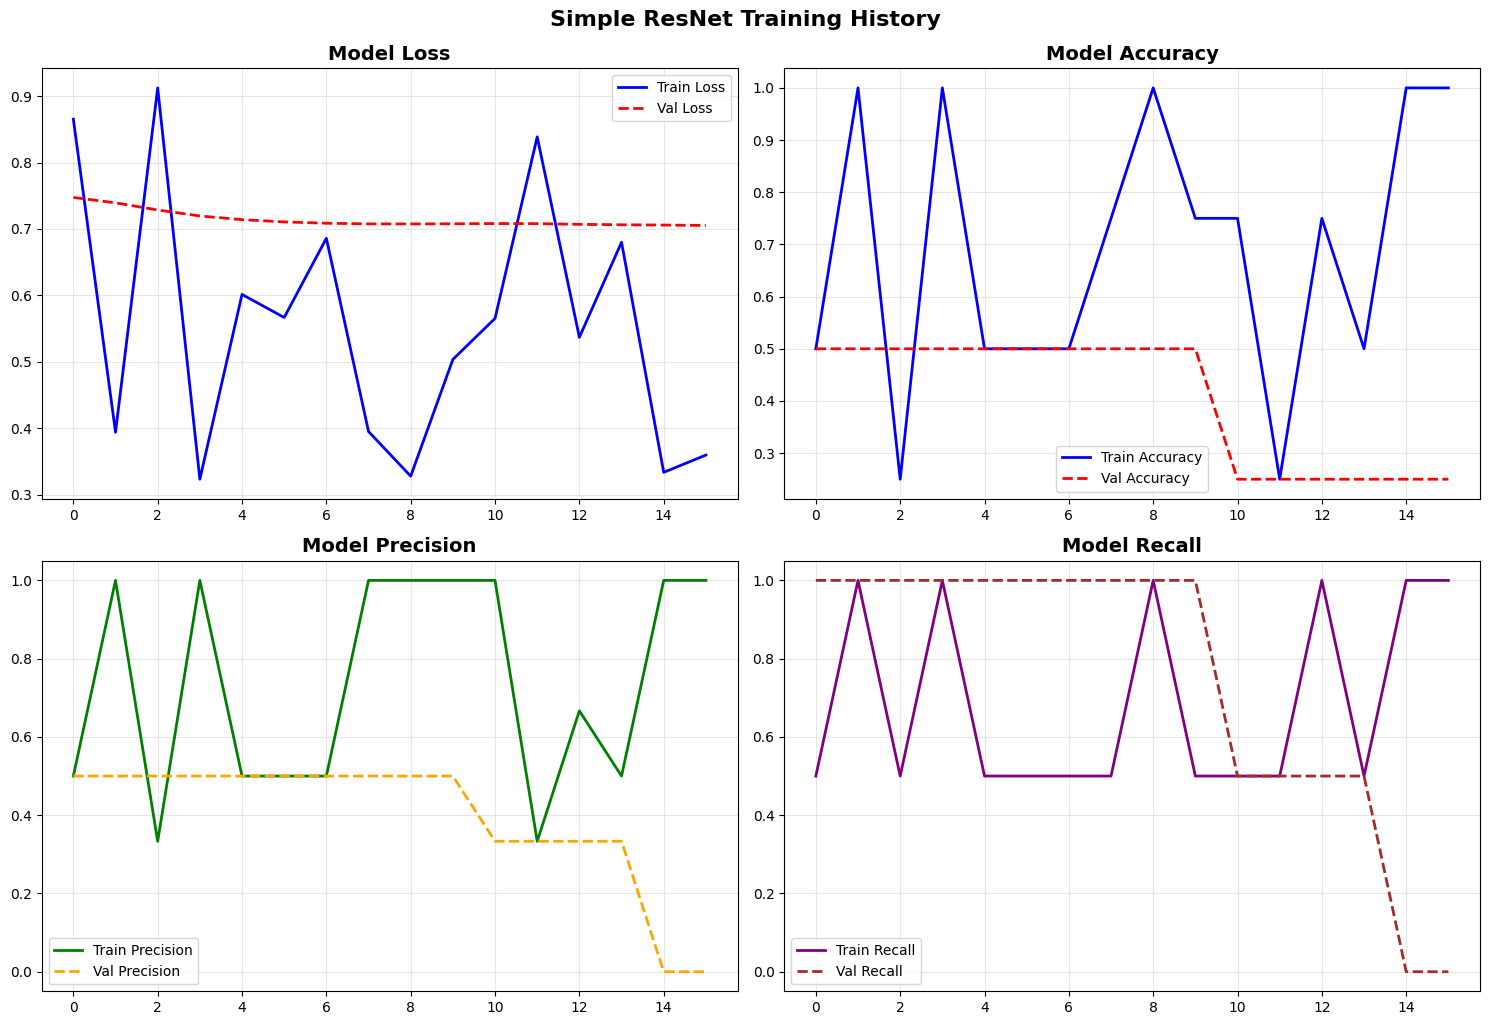

Loading best ResNet model...
Simple ResNet model loaded successfully!
Evaluating simple ResNet model on test set...
Simple ResNet model loaded successfully!
Evaluating simple ResNet model on test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

  False Positive       0.00      0.00      0.00         1
Confirmed Planet       0.50      1.00      0.67         1

        accuracy                           0.50         2
       macro avg       0.25      0.50      0.33         2
    weighted avg       0.25      0.50      0.33         2

Confusion Matrix:
[[0 1]
 [0 1]]
Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

  False Positive       0.00      0.00      0.00         1
Confirmed Planet       0.50      1.00      0.67         1

        accuracy                           0.50         2
       macro avg   

/home/kareem/Nasa_25-26/nasa_25-26/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/kareem/Nasa_25-26/nasa_25-26/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/kareem/Nasa_25-26/nasa_25-26/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

Simple ResNet Final Test Metrics:
Test Loss:      0.8761
Test Accuracy:  0.5000
Test Precision: 0.5000
Test Recall:    1.0000
Test AUC:       0.0000


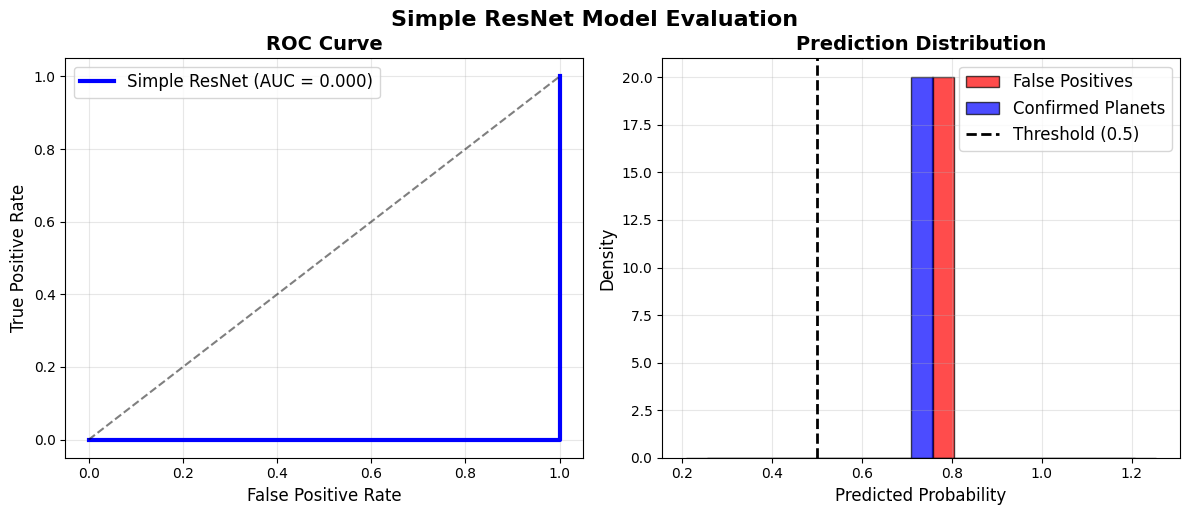

Saving model information...
Simple ResNet evaluation complete!
Model Summary:
   Model complexity: 278,897 parameters
   Test accuracy: 0.5000
   Test AUC: 0.0000
   Clean, simple, and interpretable!
   Ready for deployment!


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve
import numpy as np

def plot_simple_training_history(history):
    """Plot training metrics with clean, simple visualization"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0,0].plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2)
    axes[0,0].plot(history.history['val_loss'], label='Val Loss', color='red', linewidth=2, linestyle='--')
    axes[0,0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    axes[0,1].plot(history.history['accuracy'], label='Train Accuracy', color='blue', linewidth=2)
    axes[0,1].plot(history.history['val_accuracy'], label='Val Accuracy', color='red', linewidth=2, linestyle='--')
    axes[0,1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    axes[1,0].plot(history.history['precision'], label='Train Precision', color='green', linewidth=2)
    axes[1,0].plot(history.history['val_precision'], label='Val Precision', color='orange', linewidth=2, linestyle='--')
    axes[1,0].set_title('Model Precision', fontsize=14, fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    axes[1,1].plot(history.history['recall'], label='Train Recall', color='purple', linewidth=2)
    axes[1,1].plot(history.history['val_recall'], label='Val Recall', color='brown', linewidth=2, linestyle='--')
    axes[1,1].set_title('Model Recall', fontsize=14, fontweight='bold')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Simple ResNet Training History', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

print("Simple ResNet Training History:")
plot_simple_training_history(history)

print("Loading best ResNet model...")
try:
    best_model = tf.keras.models.load_model('models/keras/simple_resnet_model.keras')
    print("Simple ResNet model loaded successfully!")
except Exception as e:
    print(f"Loading from file failed: {e}")
    print("Using trained model directly...")
    best_model = model

print("Evaluating simple ResNet model on test set...")
test_predictions = best_model.predict([X_local_test, X_global_test, X_aux_test])

test_pred_binary = (test_predictions > 0.5).astype(int).flatten()

print(f"Classification Report (threshold = 0.5):")
print(classification_report(y_test, test_pred_binary, 
                          target_names=['False Positive', 'Confirmed Planet']))

print(f"Confusion Matrix:")
cm = confusion_matrix(y_test, test_pred_binary)
print(cm)

test_loss, test_acc, test_prec, test_rec, test_auc = best_model.evaluate(
    [X_local_test, X_global_test, X_aux_test], y_test, verbose=0
)

print(f"Simple ResNet Final Test Metrics:")
print(f"{'='*50}")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall:    {test_rec:.4f}")
print(f"Test AUC:       {test_auc:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fpr, tpr, _ = roc_curve(y_test, test_predictions)
axes[0].plot(fpr, tpr, label=f'Simple ResNet (AUC = {test_auc:.3f})', linewidth=3, color='blue')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

axes[1].hist(test_predictions[y_test == 0], bins=20, alpha=0.7, label='False Positives', 
            density=True, color='red', edgecolor='black')
axes[1].hist(test_predictions[y_test == 1], bins=20, alpha=0.7, label='Confirmed Planets', 
            density=True, color='blue', edgecolor='black')
axes[1].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1].set_xlabel('Predicted Probability', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Prediction Distribution', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Simple ResNet Model Evaluation', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print(f"Saving model information...")
os.makedirs('models', exist_ok=True)
with open('models/simple_resnet_info.txt', 'w') as f:
    f.write(f"Simple ResNet CNN for Exoplanet Detection\n")
    f.write(f"Parameters: {model.count_params():,}\n")
    f.write(f"Test Accuracy: {test_acc:.4f}\n")
    f.write(f"Test Precision: {test_prec:.4f}\n")
    f.write(f"Test Recall: {test_rec:.4f}\n")
    f.write(f"Test AUC: {test_auc:.4f}\n")